<i><h2><b>Analysis of CODE6</b></h2>

<i>

---

**Target:**

1.   Improve Model accuracy to reach stable test accuracy over 99.4
2.   Use LR Scheduler to add different learning rates to each Epoch.
3.   Change the architecture to make it more efficient.

**Results:**

1.   Parameters: 8846
2.   Best Train Acc: 99.28(13th Epoch)
3.   Best Test Acc: 99.45(9th epoch) / 99.42(13th epoch)
4.   Difference : No overfitting
5.   Epoch - 13

**Analysis:**


1.   Model gives a consistent test accuracy above 99.40 which seems to be a good sign.




**Receptive Field Calculation**

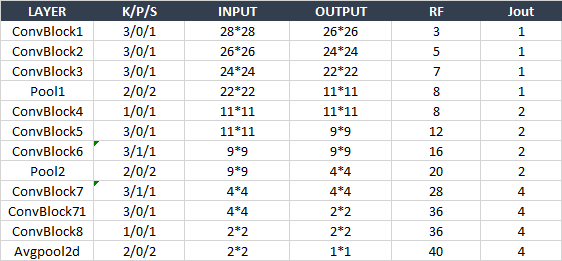

**IMPORTS**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

**DEFINE TEST/TRAIN TRANSFORMATIONS**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([ 
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**LOAD MNIST DATA**

In [3]:
train = datasets.MNIST('./data', train=True, transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform=test_transforms, download=True)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


**DATA LOADERS**

In [4]:
SEED = 1
np.random.seed(42)
torch.manual_seed(1)

#check for cuda
cuda = torch.cuda.is_available()
print('cuda available', cuda)

if cuda:
  torch.cuda.manual_seed(1)

#dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

cuda available True


**Data Stats**

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


**MODEL**

In [0]:
class Net(nn.Module):
     def __init__(self):
       super(Net, self).__init__()
       #Input block
       self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.01)
       ) # output_size = 26

       #CONV BLOCK 1
       self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(0.05)
       ) # output_size = 24

       self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(0.05)
       ) #output size = 22
      
       #TRANSITION BLOCK
       self.pool1 = nn.MaxPool2d((2,2))  #out = 11
       self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1,1),padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)
       ) #output = 11

       #CONV BLOCK 2
       self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(0.05)
       ) # output_size = 9

       self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3,3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(0.05)
       ) #out = 9

       self.pool2 = nn.MaxPool2d((2,2)) #out = 4
       self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3,3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(0.05)
       ) #out = 4

       self.convblock71 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
       ) #out = 2

       #OUTPUT BLOCK

       self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
            #nn.ReLU()
       ) #out = 2

       self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        ) # output_size = 1


     def forward(self, x):
       x = self.convblock1(x)
       x = self.convblock2(x)
       x = self.convblock3(x)
       x = self.pool1(x)
       x = self.convblock4(x)
       x = self.convblock5(x)
       x = self.convblock6(x)
       x = self.pool2(x)
       x = self.convblock7(x)
       x = self.convblock71(x)
       x = self.convblock8(x)
       x = self.gap(x)
       x = x.view(-1, 10)
       return F.log_softmax(x, dim=-1)

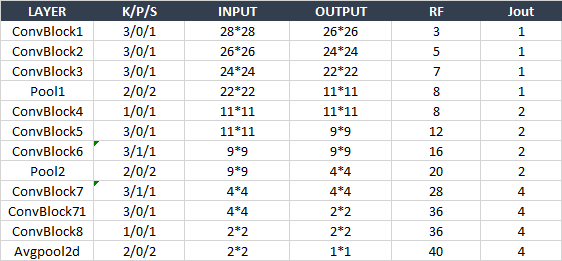

In [12]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14           [-1

**Define Train/Test functions with loss and accuracy calculations**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Training the MODEL with validation accuracy check**

In [14]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 13
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
    print('')    

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.006024077534675598 Batch_id=937 Accuracy=94.79: 100%|██████████| 938/938 [00:18<00:00, 51.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9854/10000 (98.54%)


EPOCH: 1


Loss=0.017176061868667603 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:18<00:00, 52.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9907/10000 (99.07%)


EPOCH: 2


Loss=0.07757099717855453 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:17<00:00, 52.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9910/10000 (99.10%)


EPOCH: 3


Loss=0.023600101470947266 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:18<00:00, 51.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9907/10000 (99.07%)


EPOCH: 4


Loss=0.006685391068458557 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:18<00:00, 50.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9912/10000 (99.12%)


EPOCH: 5


Loss=0.00912390649318695 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:18<00:00, 64.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)


EPOCH: 6


Loss=0.015221327543258667 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:18<00:00, 50.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)


EPOCH: 7


Loss=0.0020703375339508057 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:19<00:00, 49.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)


EPOCH: 8


Loss=0.005460426211357117 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:19<00:00, 48.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9945/10000 (99.45%)


EPOCH: 9


Loss=0.013973012566566467 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:18<00:00, 49.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)


EPOCH: 10


Loss=0.04891825467348099 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:19<00:00, 47.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9942/10000 (99.42%)


EPOCH: 11


Loss=0.01697532832622528 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:18<00:00, 49.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)


EPOCH: 12


Loss=0.11147846281528473 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:18<00:00, 51.78it/s]



Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)




Text(0.5, 1.0, 'Test Accuracy')

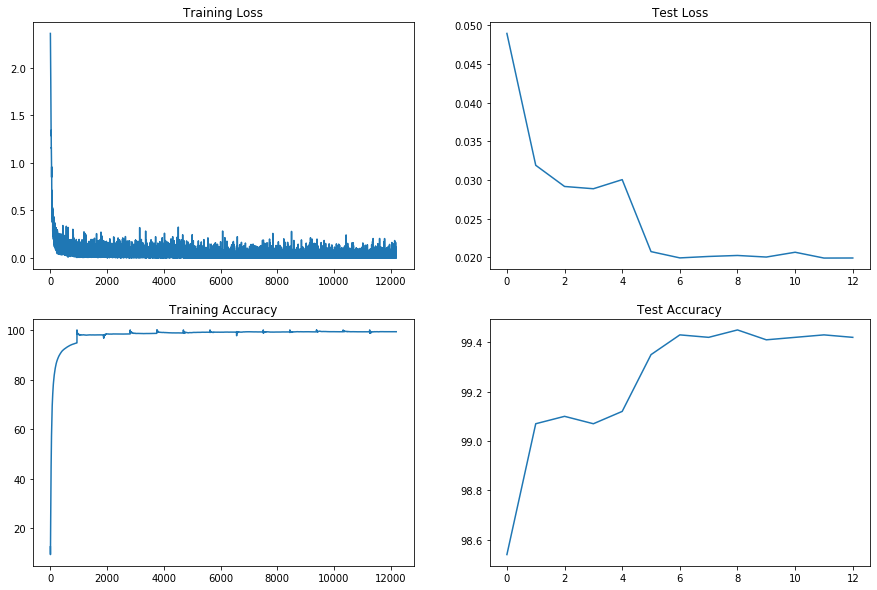

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")